In [1]:
import os
import numpy as np
import open3d as o3d
import igl
import meshplot as mp
from matplotlib import pyplot as plt
from matplotlib import cm
import math
import json
from FeatureLines import get_mesh, to_pseudo_PLY2, ReadCrestLine
from Display import mesh_lines, Colors
from Deform import Handles
from Flatten import write_TLC_input, read_TLC_result
from Transfer import crestline_mover

In [2]:
mesh_name = 'TBK_all_fixed'
neighbor = 1
mesh_file = f"{mesh_name}.ply"
ply2_name = f"{mesh_name}_k={neighbor}_ply2.txt"
V, F = get_mesh(mesh_file)
print(f"3D Lidar data: \t{mesh_file}")
print(f"neighbor value: k = {neighbor}")
print(f"PLY2 file: \t{ply2_name}")

TriangleMesh with 100406 points and 199475 triangles.
3D Lidar data: 	TBK_all_fixed.ply
neighbor value: k = 1
PLY2 file: 	TBK_all_fixed_k=1_ply2.txt


In [3]:
to_pseudo_PLY2(name=ply2_name, verts=V, faces=F, neighbor=neighbor)
crestcode_input = f"./setCurvature {ply2_name} output.txt"
print(f"in CrestCODE, enter: {crestcode_input}")

wrote neighbor value: k = 1
Success: TBK_all_fixed_k=1_ply2.txt
in CrestCODE, enter: ./setCurvature TBK_all_fixed_k=1_ply2.txt output.txt


In [4]:
import os
keeper = "ravines.txt"
here = "/Users/kronos.di.vlad/Desktop/ComputerGraphics_2023SP/Open3D_Test"
os.chdir(here)
os.rename(ply2_name, f'../CrestCODE/{ply2_name}')

In [5]:
os.chdir('../CrestCODE/')
os.system('pwd')
os.system(crestcode_input)

/Users/kronos.di.vlad/Desktop/ComputerGraphics_2023SP/CrestCODE
number of boundary points = 1339


0

In [6]:
os.system('rm ridges.txt')
os.system(f'rm {ply2_name}')
os.system('rm output.txt')

0

In [7]:
os.system('pwd')
os.rename('ravines.txt', f'../Open3d_Test/ravines.txt')

/Users/kronos.di.vlad/Desktop/ComputerGraphics_2023SP/CrestCODE


In [8]:
os.chdir(here)
os.system('pwd')

/Users/kronos.di.vlad/Desktop/ComputerGraphics_2023SP/Open3D_Test


0

In [9]:
PALETTE = Colors()
crestline_V_3d, crestline_E = ReadCrestLine(keeper)
plot_3d = mp.plot(v=V, f=F, c=PALETTE.GREY)
plot_3d.add_lines(beginning=crestline_V_3d[crestline_E[:,0]], 
                  ending=crestline_V_3d[crestline_E[:,1]], 
                  shading={"line_color": "red", "line_width": 10000.0})
# mesh_lines(vertices=V, faces=F, plot=plot_3d, color="black")
plot_3d.add_points(points=crestline_V_3d, c='red', shading={"point size": 100})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5073857…

2

In [10]:
grey = np.array([0.99, 0.99, 0.99]) # grey

mesh_color = np.zeros(shape=V.shape)
mesh_color[:, :] = PALETTE.GREY
mesh_color[0] = PALETTE.TURQUOISE

handle_dictionary = {
    19841:  [1.2001, 1.7609, 0],
    12438:  [1.2602, 1.9212, 0],
    26200:  [1.1260, 1.5211, 0],
    31800:  [1.5027, 1.5738, 0], # check
    33350:  [1.7278, 1.5671, 0],
    78265:  [2.1373, 1.7553, 0],
    81096:  [2.2855, 1.5940, 0],
    21838:  [1.3301, 2.1361, 0], # group 1 end
    68046:  [1.9483, 2.1550, 0],
    27896:  [1.4107, 2.4159, 0],
    58194:  [1.9082, 2.3955, 0],
    11679:  [1.7145, 2.6293, 0], # check
    44274:  [0.5692, 1.5454, 0],
    21332:  [0.7124, 1.6473, 0],
    97337:  [2.1430, 1.0793, 0],
    78209:  [1.7947, 1.0460, 0]
}

handle_ids = list(handle_dictionary.keys())
print(f"number of handles: {len(handle_ids)}")
handle_pos = np.asarray([handle_dictionary[id] for id in handle_dictionary])
print(f"handle position shape: {handle_pos.shape}")
handle_current_pos = V[handle_ids]
# print(f"current handle positions: \n{handle_current_pos}")
# handle_color = [red for i in handle_ids]
handle_colors = np.asarray([
    PALETTE.BLUE,   PALETTE.BLUE,   PALETTE.GREEN,  PALETTE.YELLOW, PALETTE.BLACK,  PALETTE.PURPLE, PALETTE.TURQUOISE, PALETTE.GREY,
    PALETTE.RED,    PALETTE.BLUE,   PALETTE.GREEN,  PALETTE.YELLOW, PALETTE.BLACK,  PALETTE.PURPLE, PALETTE.TURQUOISE, PALETTE.GREY])
# print(f"target handle positions: \n{handle_pos}")
arap_before = mp.plot(v=V, f=F, c=mesh_color)
arap_before.add_points(points=handle_current_pos + np.asarray([0, 0, 0.005]),
                          c=handle_colors,
                          shading={"point_size": 0.1})
arap_before.add_points(points=handle_pos + np.asarray([0, 0, -0.15]), 
                          c=handle_colors,
                          shading={"point_size": 1})
print(f"big points: handle TARGET positions")
# mesh_lines(vertices=V, faces=F, plot=arap_before, color="black")
arap_before.add_lines(beginning=handle_current_pos, ending=handle_pos, 
                      shading={"line_color": "blue", "line_width": 1000.0})

arap_before.add_lines(beginning=crestline_V_3d[crestline_E[:,0]], 
                  ending=crestline_V_3d[crestline_E[:,1]], 
                  shading={"line_color": "blue", "line_width": 1000.0})

number of handles: 16
handle position shape: (16, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5073857…

big points: handle TARGET positions


4

In [119]:
handle_ids_b = np.asarray([[id] for id in handle_ids])
arap_object = igl.ARAP(V, F, 3, handle_ids)
V_arap_igl = arap_object.solve(handle_pos, V)
# print(max(V_arap_igl[:,0]))
# print(max(V_arap_igl[:,1]))
# print(max(V_arap_igl[:,2]))

In [120]:
# libigl runs faster (after adding libigl's precomputation time)
arap_result = mp.plot(v=V_arap_igl, f=F, c=PALETTE.GREEN)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5086220…

In [ ]:
# V_arap_o3d = Handles(mesh_vertices=V, mesh_faces=F,
#     affected_vertex_ids=handle_ids, target_positions=handle_pos, iterations=10
# )
# arap_result_o3d = mp.plot(v=V_arap_o3d, f=F, c=PALETTE.GREEN)

In [ ]:
# 1 get 10 handles
# use meshlab to select vertices visually and get their indices
# 2 can code run fast enough
# test out with entire mesh (with handles), see the speed

In [132]:
TLC_filename = f"{mesh_name}_tlc.txt"
flat_filename = f"{mesh_name}_2d.txt"
write_TLC_input(
    filename=TLC_filename,
    restVert=V,
    initVert=V_arap_igl[:,0:2],
    triangles=F,
    handles=np.asarray(handle_ids))
print(f"the TLC file is: {TLC_filename}")
SEA_input = f"./SEA_QN {TLC_filename} solver_options.txt {flat_filename}"
print(f"in SEA, enter: {SEA_input}")

the TLC file is: TBK_all_fixed_tlc.txt
in SEA, enter: ./SEA_QN TBK_all_fixed_tlc.txt solver_options.txt TBK_all_fixed_2d.txt


In [133]:
os.chdir(here)
os.rename(TLC_filename, f"../SEA_folder/cmake-build-debug/{TLC_filename}")
os.chdir('../SEA_folder/cmake-build-debug')
os.system('pwd')
os.system(SEA_input)

/Users/kronos.di.vlad/Desktop/ComputerGraphics_2023SP/SEA_folder/cmake-build-debug
form: harmonic
alphaRatio: 1e-05
alpha: 9.80572e-06
theta: 0.1
Time difference: 118009148 [microseconds]
result: XTOL_REACHED
met custom stop criteria (none): no
36 iterations
52 function/gradient evaluations
TLC time: 58.8581 seconds.
arc segment time: 0.150707 seconds.
arc occupancy time: 53.5772 seconds.
- arc arrangement time: 52.9065 seconds.
** subdivide polyArc time: 52.0931 seconds.
### arc intersection init time: 0.122269 seconds.
### arc bbox intersection test time: 12.5633 seconds.
### arc-arc intersection time: 38.0651 seconds.
### arc subdivision time: 0.0243361 seconds.
** decompose into cells time: 0.214591 seconds.
** compute cells windings time: 0.295397 seconds.


0

In [136]:
os.rename(flat_filename, f'../../Open3D_Test/{flat_filename}')
os.system(f'rm {TLC_filename}')

In [138]:
os.chdir(here)
dictionary = read_TLC_result(flat_filename)
V_2d = np.zeros(V.shape)
V_2d[:,0:2] = dictionary["resV"]
flat_plot = mp.plot(v=V_2d, f=F, c=mesh_color)
flat_plot.add_points(
  points=V_2d[handle_ids] + [0, 0, 0.005], c=handle_colors, shading={"point_size": 2})
mesh_lines(vertices=V_2d, faces=F, plot=flat_plot, color="black")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5086220…

In [140]:
print(crestline_V_3d.shape)
# print(crestline_V_3d[0])
mover = crestline_mover( 
            mesh_3d_vertices=V, mesh_faces=F, 
            mesh_3d_crestlines_vertices=crestline_V_3d, 
            crestline_edges=crestline_E, 
            mesh_2d_vertices=V_2d, color=mesh_color)
flat_plot_lines = mp.plot(v=V_2d, f=F, c=mesh_color)

# flat_plot_lines.add_edges(vertices=mover.mesh_2d_crestlines_vertices, 
#                           edges=crestline_E, 
#                           shading={"line_color": "green"})
flat_plot_lines.add_lines(
                  beginning=mover.mesh_2d_crestlines_vertices[crestline_E[:,0]], 
                  ending=mover.mesh_2d_crestlines_vertices[crestline_E[:,1]], 
                  shading={"line_color": "blue", "line_width": 1000.0})

flat_plot_lines.add_points(
  points=V_2d[handle_ids] + [0, 0, 0.005], # <- big points: where the small points WILL BE
  c=handle_colors,
  shading={"point_size": 2})
# mesh_lines(vertices=V_2d, faces=F, plot=flat_plot_lines, color="black")

(28567, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.5086220…

2

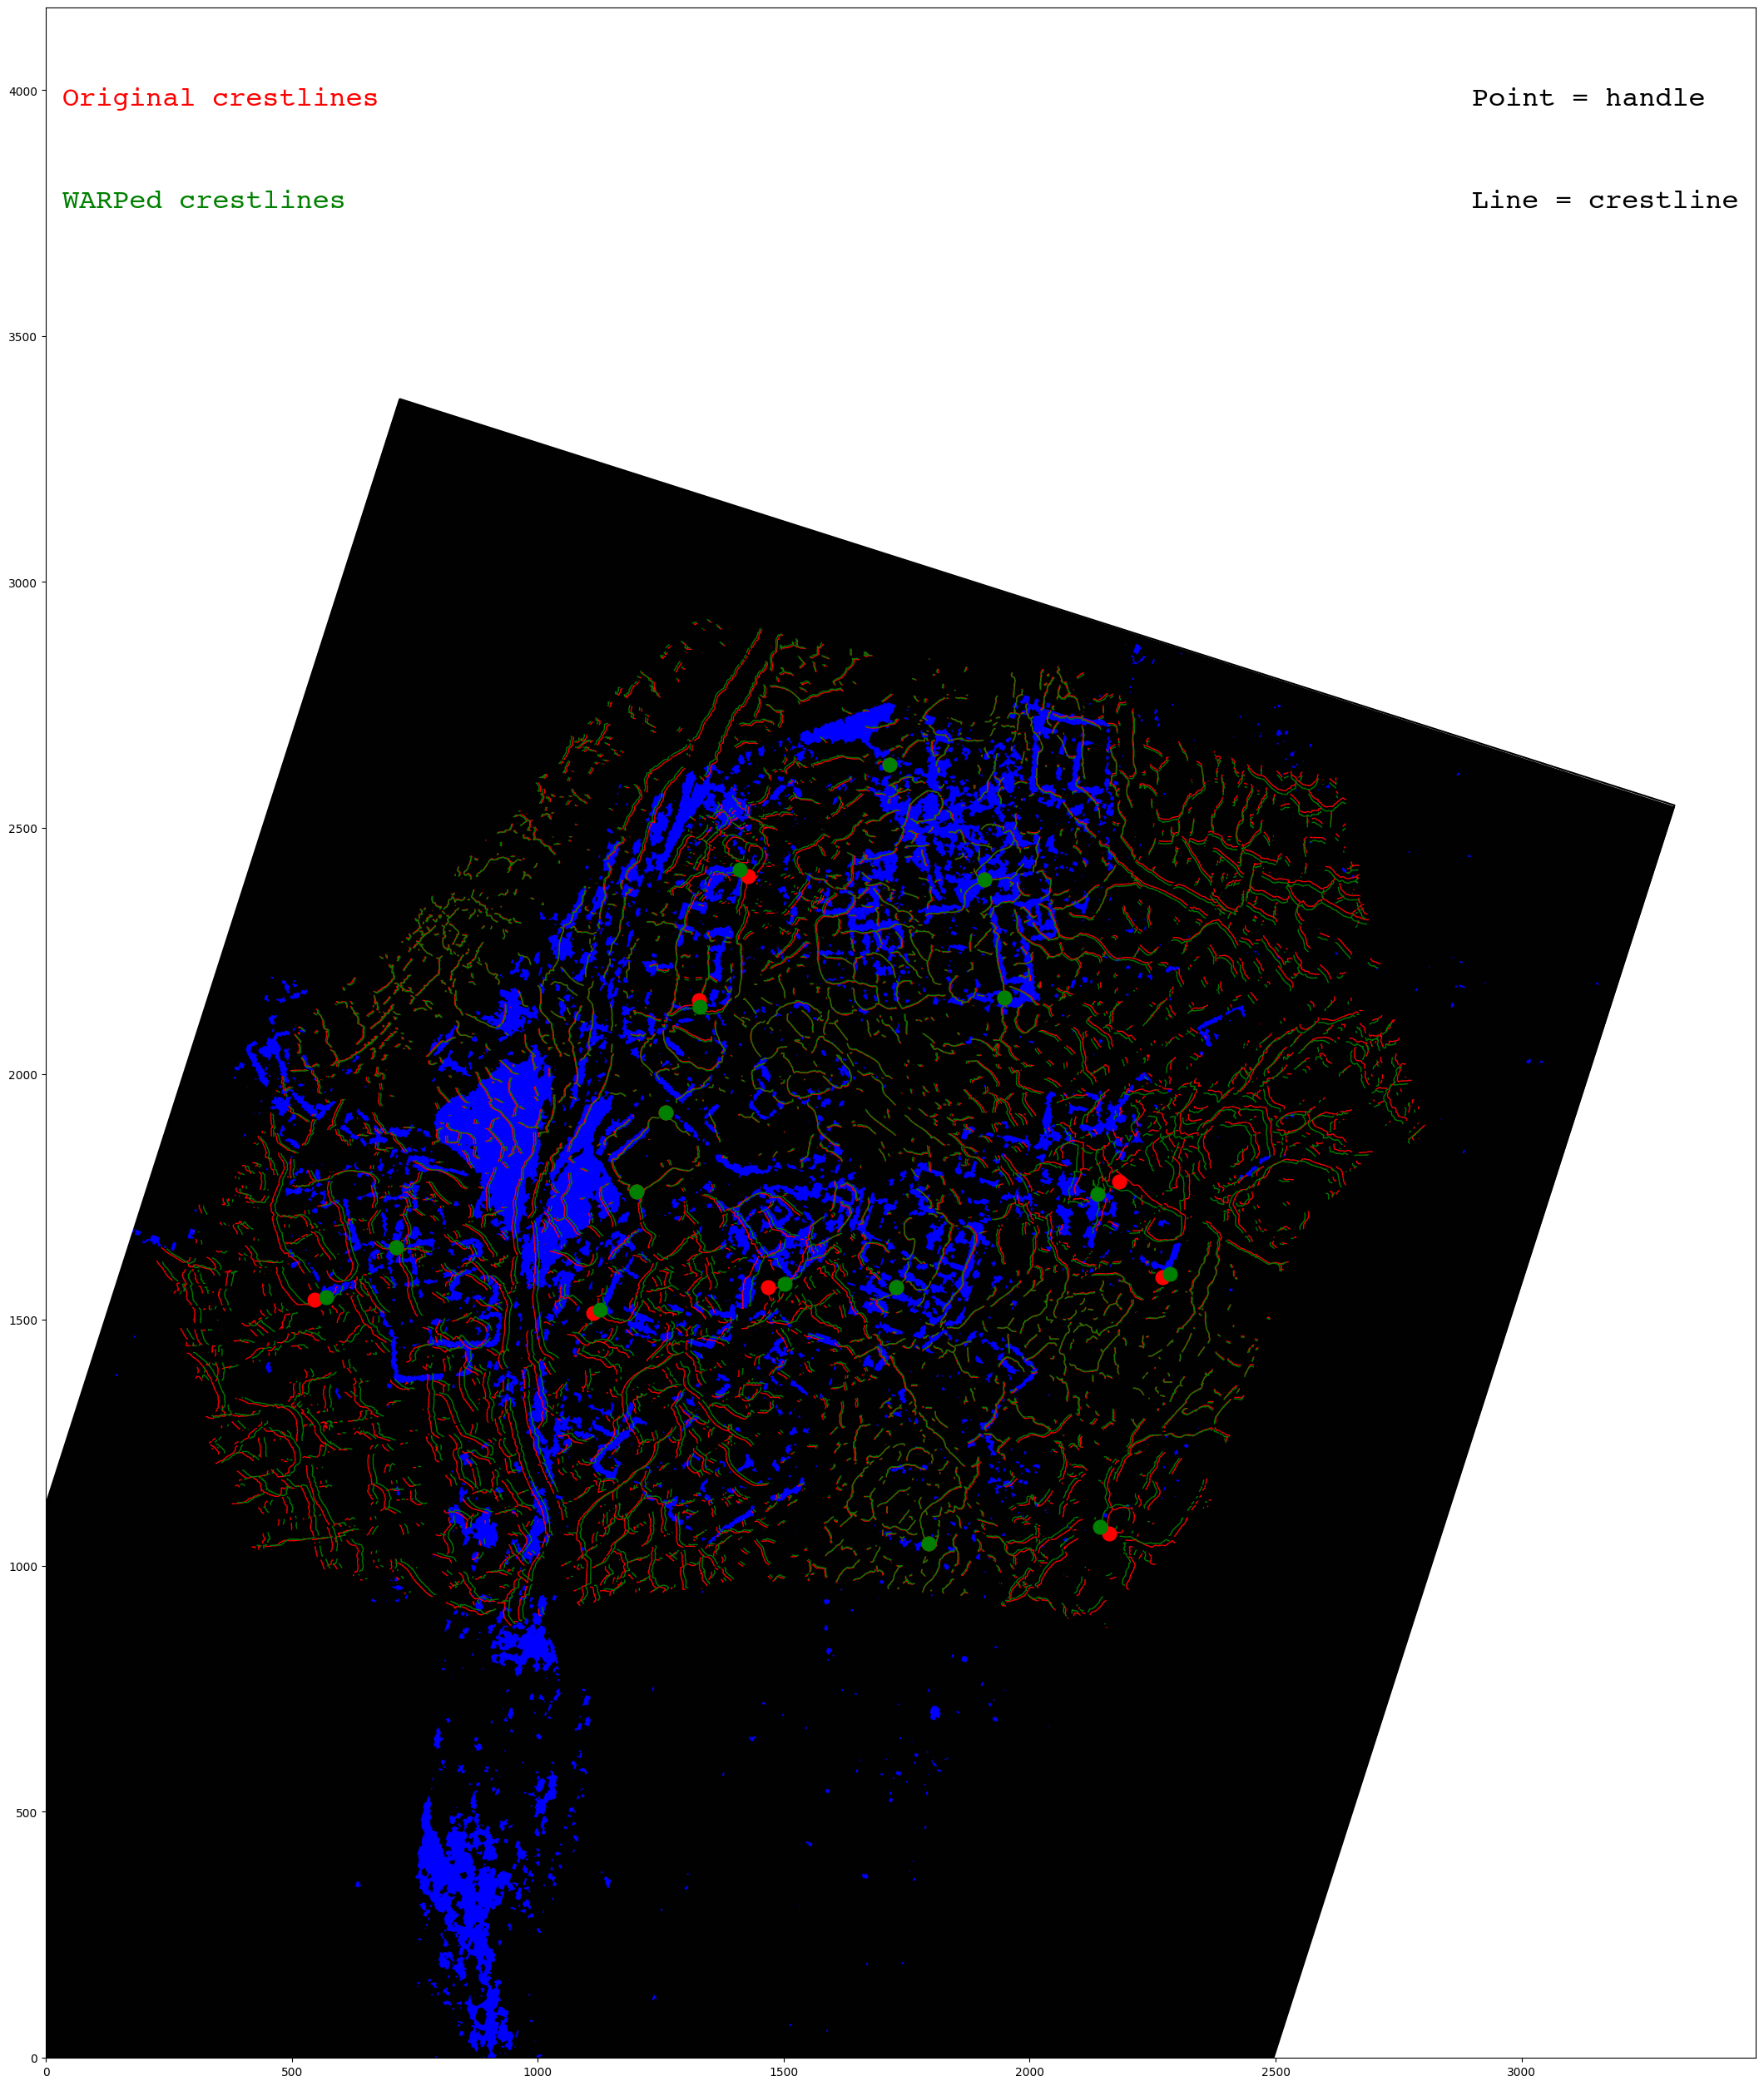

<Figure size 640x480 with 0 Axes>

In [601]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
from PIL import Image

f, ax = plt.subplots(figsize=(32, 32)) # NOT subplot()
# plt.figure(figsize=(36, 36))
ax.set_xlim(0, 300)
ax.set_ylim(0, 300)
init_color = 'red'
warp_color = 'green'

# imageFile = "Export_230328"
imageFile = '25~89_dual_color.png'
# img=mpimg.imread(imageFile)
img = Image.open(imageFile)
img = np.flip(img, axis=1)
y_length, x_length, channel = img.shape

imgplot = plt.imshow(img)
tx, ty = [0, 0]
transform = mpl.transforms.Affine2D().translate(-x_length/2, -y_length/2)
transform = transform.rotate(np.deg2rad(180))
transform = transform.scale(0.855) # need conversion
transform = transform.rotate(np.deg2rad(-17.7447))
transform = transform.translate(1470, 1260) # same amount as in blender
imgplot.set_transform(transform + ax.transData)

# x = [0, 1363, 1363] # scaling
# y = [1786, 1786, 0]
# plt.plot(x, y)
x = [0, 720, 3311, 2494] # rotating (image border)
y = [1113, 3372, 2546, 0]
plt.plot(x, y, color='black')
# x = [0, 3314] # translating
# y = [2541, 2541]
# plt.plot(x, y)
"""handles (points)"""
handle_coords_x = []
handle_coords_y = []
origin_coords_x = []
origin_coords_y = []
handle_number = 0
for key in handle_dictionary.keys():
        x, y, _ = (handle_dictionary[key])
        handle_coords_x.append(x * 1000)
        handle_coords_y.append(y * 1000)
        # plt.plot(x, y, 'o', markersize=20, color='red')
        # plt.annotate(handle_number, (x * 1000, y * 1000), fontsize=36, color='blue')
        x, y, _ = V[key]
        origin_coords_x.append(x * 1000)
        origin_coords_y.append(y * 1000)
        handle_number += 1
plt.plot(origin_coords_x, origin_coords_y, 'o', markersize=12, color=init_color)
plt.plot(handle_coords_x, handle_coords_y, 'o', markersize=12, color=warp_color)
"""crestlines (lines)"""
# for i, j, _ in crestline_E: # <- plot ea segment individ, SUPER slow!
#         # print(crestline_V_3d[i])
#         # print(crestline_V_3d[j])
#         x1, y1, _ = crestline_V_3d[i] * 1000
#         x2, y2, _ = crestline_V_3d[j] * 1000
#         segment_3d_x = [x1, x2]
#         segment_3d_y = [y1, y2]
#         plt.plot(segment_3d_x, segment_3d_y, color=init_color)
#         x1, y1, _ = mover.mesh_2d_crestlines_vertices[i] * 1000
#         x2, y2, _ = mover.mesh_2d_crestlines_vertices[j] * 1000
#         segment_2d_x = [x1, x2]
#         segment_2d_y = [y1, y2]
#         plt.plot(segment_2d_x, segment_2d_y, color=warp_color)
#         # print(f"segment from {x1, y1} to {x2, y2}")
#         # break
from matplotlib import collections as mc # W method, FAST!
init_lines = [] # item = [(start coord tuple), (end coord tuple)]
warp_lines = []
for i, j, _ in crestline_E:
        x1, y1, _ = crestline_V_3d[i] * 1000
        x2, y2, _ = crestline_V_3d[j] * 1000
        init_lines.append([(x1, y1), (x2, y2)])
        x1, y1, _ = mover.mesh_2d_crestlines_vertices[i] * 1000
        x2, y2, _ = mover.mesh_2d_crestlines_vertices[j] * 1000
        warp_lines.append([(x1, y1), (x2, y2)])
init_line_collection = mc.LineCollection(init_lines, colors=init_color, linewidths=1)
warp_line_collection = mc.LineCollection(warp_lines, colors=warp_color, linewidths=1)
ax.add_collection(init_line_collection)
ax.add_collection(warp_line_collection)

COURIER = {'fontname':'Courier'}
ax.text(0.01, 0.95, 'Original crestlines',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color=init_color, fontsize=24, **COURIER)
ax.text(0.01, 0.90, 'WARPed crestlines',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color=warp_color, fontsize=24, **COURIER)
ax.text(0.99, 0.95, 'Point = handle  ',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=24, **COURIER)
ax.text(0.99, 0.90, 'Line = crestline',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=24, **COURIER)

ax.autoscale()
current_figure = plt.gcf()
plt.show()
plt.draw()
current_figure.savefig('PLOT.png', dpi=240, bbox_inches='tight')

In [141]:
def export_lines(vertices, edges, filename):
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(vertices),
        lines=o3d.utility.Vector2iVector(edges),
    )
    o3d.io.write_line_set(filename, line_set, print_progress=True)

export_lines(vertices=crestline_V_3d,
             edges=crestline_E[:,0:2].astype(int),
             filename=f"{mesh_name}_3d_lines.ply")
export_lines(vertices=mover.mesh_2d_crestlines_vertices,
             edges=crestline_E[:,0:2].astype(int),
             filename=f"{mesh_name}_2d_lines.ply")

Writing PLY: [========================================] 100%
Writing PLY: [========================================] 100%


In [208]:
print(max(V_2d[:,0]))
print(max(mover.mesh_2d_crestlines_vertices[:,0]))
print(max(V_2d[:,1]))
print(max(mover.mesh_2d_crestlines_vertices[:,1]))

2.808697865829617
2.7954779877123137
2.966074348018724
2.8924007757736607
